In [1]:
!nvidia-smi

Sun Jan 16 15:41:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 495.46       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:08:00.0 Off |                  Off |
| 30%   31C    P8    16W / 230W |   5040MiB / 24256MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Entry point

In [2]:
import sys
if "modist/src" not in sys.path:
    sys.path.append("../src")

In [3]:
from modist.modist_pcm_dataset import ModistPcmAnDataset, get_modist_pcm_collate_fn
from modist.mp3_info import get_lang_encoder
from modist.data_split import split_mp3

In [4]:
import json
with open("../data/abo16_an_splits.json") as fin:
    split = json.load(fin)
mp3_prefix = "../data/anpcm/"
train_mp3 = [(mp3_prefix+x[0].replace(".mp3", ".pcm"), *x[1:]) for x in split["train"]]
test_mp3 = [(mp3_prefix+x[0].replace(".mp3", ".pcm"), *x[1:]) for x in split["test"]]

In [5]:
import random
from itertools import islice
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import wandb
import torchmetrics
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForPreTraining, Wav2Vec2Model, Wav2Vec2Config
from transformers.models.wav2vec2.modeling_wav2vec2 import _compute_mask_indices, _sample_negative_indices
from transformers.optimization import get_cosine_schedule_with_warmup

## Setup condition

In [7]:
condition = "abo16-an"
pretrained_base = "xlsr"
randomize_seg = True
random_seed = 12121
speech_only = True
limit_data_prop = None # for debug use, set to None in real training
print(f"Running finetune condition _{condition}_, with pretrain base _{pretrained_base}_")
print(f"speech_only: {speech_only}")
print(f"randomize_seg: {randomize_seg}")
print(f"limit_data_prop: {limit_data_prop}")

Running finetune condition _abo16-an_, with pretrain base _xlsr_
speech_only: True
randomize_seg: True
limit_data_prop: None


## Prepare Dataset

In [8]:
lang_encoder = get_lang_encoder("../data/abo16_lang_map.csv")
wv2_pt_model_name = "facebook/wav2vec2-large-xlsr-53"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(wv2_pt_model_name)
train_dataset = ModistPcmAnDataset(train_mp3, speech_only=True, limit_data_prop=limit_data_prop)
test_dataset = ModistPcmAnDataset(test_mp3, speech_only=True, limit_data_prop=limit_data_prop)
collate_fn = get_modist_pcm_collate_fn(feature_extractor, lang_encoder, train_dataset.sample_rate)

In [9]:
n_train = len(train_dataset.inventory)
len(train_dataset.inventory), len(test_dataset.inventory)

(13579, 2276)

In [10]:
train_dataset[1001]

{'pcm_lang': 'Thau',
 'category': 'speech',
 'ss': 84,
 'ee': 87,
 'samples': memmap([473, 113, -63, ..., 933, 949, 984], dtype=int16)}

In [11]:
train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=collate_fn, drop_last=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn, drop_last=True)

In [12]:
batch_z = next(iter(train_loader))
print(batch_z["tensorX"].shape, batch_z["lang"])

torch.Size([16, 48000]) tensor([14, 11,  1, 10,  0, 13,  3, 10,  4,  4, 15,  3, 14, 10,  3, 16])


## Model configuration

In [12]:
# initialize wandb first to download artifact
wandb.init(project='abo16-an', name=f'abo16-an-02', reinit=True, 
           notes="AN data, 10 epochs, lr=1e-3, cosine scheduler with 200 steps warmup")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: seantyh (use `wandb login --relogin` to force relogin)


In [13]:
import glob
config = Wav2Vec2Config.from_pretrained(wv2_pt_model_name)

In [14]:
class Abo16AnFineTune(pl.LightningModule):
    def __init__(self, w2v_config, num_class, wv2_pretrained=None, lr=1e-3, n_train=1000):
        super().__init__()
        if wv2_pretrained:
            self.wav2vec2 = Wav2Vec2Model.from_pretrained(wv2_pretrained)
        else:
            self.wav2vec2 = Wav2Vec2Model(w2v_config)        
        self.classifier = nn.Linear(w2v_config.hidden_size, num_class)
        self.loss_fn = nn.CrossEntropyLoss()
        self.n_train = n_train
        self.save_hyperparameters()    
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()    

    def forward(self, X):        
        batch_size = X.size(0)
        h = self.wav2vec2(X)
        o = self.classifier(h.last_hidden_state[:, 0, :])
        return o

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, 200, n_train*self.trainer.max_epochs)
        return {
            "optimizer": optimizer, "lr_scheduler": scheduler
        }

    def training_step(self, train_batch, batch_idx):
        logits = self.forward(train_batch["tensorX"])
        lang_ids = train_batch["lang"]
        loss = self.loss_fn(logits, lang_ids)
        preds = logits.argmax(dim=1)    
        self.train_acc(preds, lang_ids)
        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        logits = self.forward(val_batch["tensorX"])
        lang_ids = val_batch["lang"]
        loss = self.loss_fn(logits, lang_ids)
        preds = logits.argmax(dim=1)
        self.val_acc(preds, lang_ids)    
        self.log('train_loss', loss)
        self.log('val_acc', self.val_acc, on_step=True, on_epoch=False)
        self.log('val_acc_epoch', self.val_acc, on_step=False, on_epoch=True)
        return loss

    def predict_step(self, test_batch, batch_idx):
        X = test_batch["tensorX"]    
        h = self.wav2vec2(X, output_hidden_states=True)
        logits = self.classifier(h.last_hidden_state[:, 0, :])
        preds = logits.argmax(dim=1)

        if "lang" in test_batch:
            ans = test_batch["lang"]
            return {"preds": preds, "ans": ans,               
                  "last": h.last_hidden_state[:, 0, :].cpu().numpy(),
                  "h0": h.hidden_states[0][:, 0, :].cpu().numpy(),
                  "h6": h.hidden_states[6][:, 0, :].cpu().numpy()}
        else:
            return preds


## Training

In [16]:
model = Abo16AnFineTune(config, len(lang_encoder.classes_), 
                         wv2_pretrained=wv2_pt_model_name,
                        lr=1e-3, 
                        n_train=len(train_dataset))

wandb_logger = WandbLogger()
model_ckpt = ModelCheckpoint(
    monitor='val_acc_epoch', mode='max',
    save_weights_only=True, every_n_epochs=1)
trainer = pl.Trainer(fast_dev_run=False, gpus=1, logger=wandb_logger, 
                     max_epochs=10, log_every_n_steps=20,                      
                     callbacks=[model_ckpt])
trainer.fit(model, train_loader, test_loader)

Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2Model: ['quantizer.weight_proj.bias', 'project_q.bias', 'quantizer.weight_proj.weight', 'quantizer.codevectors', 'project_hid.bias', 'project_q.weight', 'project_hid.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/seantyh/miniconda3/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarn

Validation sanity check: 0it [00:00, ?it/s]

/home/seantyh/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/seantyh/miniconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/seantyh/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [17]:
model_ckpt.best_model_path

'/home/seantyh/langon/modist/var/abo16-an/2knt9rhb/checkpoints/epoch=6-step=5935.ckpt'

In [20]:
# manually copy the best model path to abo16-an

## Evaluation

In [15]:
model = Abo16AnFineTune.load_from_checkpoint("abo16-an/abo16-an-02.ckpt")
evaler = pl.Trainer(fast_dev_run=False, gpus=1)
evals = evaler.predict(model, test_loader)

Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2Model: ['project_hid.bias', 'quantizer.weight_proj.bias', 'quantizer.codevectors', 'project_hid.weight', 'project_q.weight', 'quantizer.weight_proj.weight', 'project_q.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/seantyh/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: U

Predicting: 0it [00:00, ?it/s]

In [17]:
def flatten(x):
    return (y for _x in x for y in _x)
preds_iter = flatten(x["preds"] for x in evals)
ans_iter = flatten(x["ans"] for x in evals)
preds = [lang_encoder.classes_[x] for x in preds_iter]
ans = [lang_encoder.classes_[x] for x in ans_iter]


In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
accuracy_score(ans, preds)

0.8765377855887522

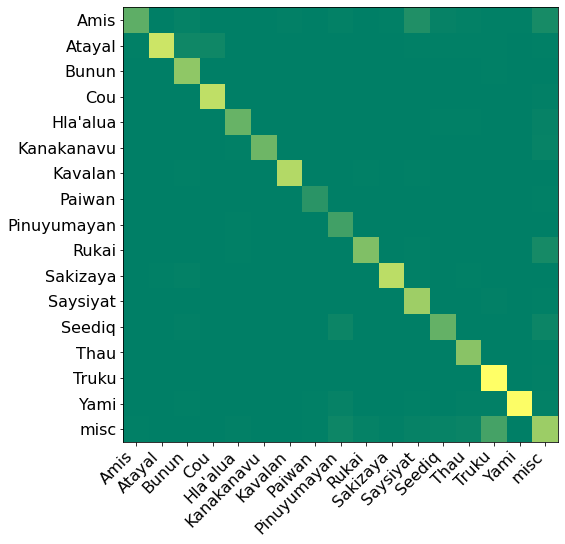

In [20]:
import matplotlib.pyplot as plt
import numpy as np

cmat = confusion_matrix(ans, preds)
plt.figure(figsize=(8,8))
plt.imshow(cmat, cmap="summer")
plt.gca().set_xticks(np.arange(17))
plt.gca().set_yticks(np.arange(17))
plt.gca().set_xticklabels(lang_encoder.classes_, rotation='45', ha='right', size=16)
plt.gca().set_yticklabels(lang_encoder.classes_, size=16)
plt.show()

In [23]:
print(classification_report(ans, preds))

              precision    recall  f1-score   support

        Amis       0.97      0.54      0.69       140
      Atayal       0.99      0.84      0.91       192
       Bunun       0.83      0.99      0.90       115
         Cou       0.93      0.99      0.96       154
    Hla'alua       0.94      0.92      0.93        89
  Kanakanavu       1.00      0.93      0.96        95
     Kavalan       0.99      0.98      0.98       145
      Paiwan       0.94      0.97      0.96        35
 Pinuyumayan       0.65      0.98      0.78        54
       Rukai       0.95      0.84      0.89       122
    Sakizaya       0.98      0.96      0.97       155
    Saysiyat       0.78      0.98      0.87       129
      Seediq       0.86      0.78      0.82       102
        Thau       0.87      0.99      0.93       110
       Truku       0.77      0.99      0.86       205
        Yami       1.00      0.93      0.96       215
        misc       0.64      0.57      0.60       219

    accuracy              

## Make vectors

In [24]:
import numpy as np
last_hiddens = np.concatenate([x["last"] for x in evals])
h6_hiddens = np.concatenate([x["h0"] for x in evals])
h0_hiddens = np.concatenate([x["h6"] for x in evals])

In [27]:
import pickle
vec_path = "../data/vecs/abo16-an-02.vec.pkl"

with open(vec_path, "wb") as fout:
    pickle.dump({"preds": preds, "ans": ans, "last": last_hiddens, 
                 "h6": h6_hiddens, "h0": h0_hiddens}, fout)